<a href="https://colab.research.google.com/github/TayJen/hackathon_algu2022/blob/master/H_ALGU_2022_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/Shareddrives/data_drive/H_Vladivostok2022
!pwd

/content/drive/Shareddrives/data_drive/H_Vladivostok2022
/content/drive/Shareddrives/data_drive/H_Vladivostok2022


## Импорт библиотек

In [3]:
# Для работы с данными
import numpy as np
import pandas as pd

# Для визуализации
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Для работы с текстом
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.probability import FreqDist
from nltk.corpus import wordnet, stopwords
from pymystem3 import Mystem

# Для моделей
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

# Метрика
from sklearn.metrics import r2_score

%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'
np.random.seed(59)

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Работа с данными

## Основные данные

Считываем

In [4]:
df_train = pd.read_csv("./data/train/train_issues.csv")
df_test = pd.read_csv('./data/test/test_issues.csv')

Работа со временем

In [5]:
for df in df_train, df_test:
    df['created_time'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')
    df['month'] = df['created_time'].dt.month
    df['day'] = df['created_time'].dt.day
    df['hour'] = df['created_time'].dt.hour

    df.drop(['created', 'created_time'], axis=1, inplace=True)

df_train.head()

,id,key,summary,project_id,assignee_id,creator_id,overall_worklogs,month,day,hour
0,819952,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,10,1,5
1,819949,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200,10,1,5
2,819947,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400,10,1,6
3,819943,SM-10682,"UI тесты раздела ""Новости""",5,93,93,900,10,1,6
4,819941,SM-10683,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900,10,1,6


Работа с ключем задачи

In [6]:
for df in df_train, df_test:
    df['key_name'] = df['key'].apply(lambda x: x.split('-')[0])
    df['key_num'] = df['key'].apply(lambda x: x.split('-')[1]).astype('int64')

    df.drop(['key'], axis=1, inplace=True)

df_train.head()

,id,summary,project_id,assignee_id,creator_id,overall_worklogs,month,day,hour,key_name,key_num
0,819952,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,10,1,5,SM,10678
1,819949,"UI тесты раздела ""Профиль""",5,93,93,7200,10,1,5,SM,10679
2,819947,"UI тесты раздела ""Личный счет""",5,93,93,14400,10,1,6,SM,10680
3,819943,"UI тесты раздела ""Новости""",5,93,93,900,10,1,6,SM,10682
4,819941,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900,10,1,6,SM,10683


In [7]:
df_train.key_name.unique(), df_test.key_name.unique()

(array(['SM', 'BALT', 'BA', 'UN', 'FPY', 'XXO', 'ADBK', 'ADBKRK', 'LJ'],
       dtype=object),
 array(['SM', 'BALT', 'BAD', 'UN', 'FPY', 'XXO', 'ADBK', 'ADBKRK', 'LJ'],
       dtype=object))

Явная опечатка

In [8]:
df_train['key_name'] = df_train['key_name'].apply(lambda x: 'BAD' if x == 'BA' else x)
set(df_train.key_name.unique()) == set(df_test.key_name.unique())

True

Работа с описанием задачи

In [9]:
m = Mystem()
lemmatizer = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()

Для того чтобы лемматизация работала, необходимо раскомментировать первые две строки при первом запуске

In [10]:
# !wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
# !tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /root/.local/bin/mystem

In [11]:
def clear_text(text):
    t = re.sub(r'[^a-zA-Zа-яА-ЯёЁ\' ]', ' ', text)
    t = ' '.join(t.split())
    return t.lower()

def lemmatize_text_rus(text):
    tokens = m.lemmatize(text)
    tokens = [token for token in tokens if token != '\n']
    text = " ".join(tokens)
    
    return text

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatize_with_pos_eng(text):
    pos_tagged = nltk.pos_tag(w_tokenizer.tokenize(text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, pos=tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence


for df in df_train, df_test:
    df['clear_summary'] = df['summary'].apply(clear_text)
    df['lemm_summary'] = df['clear_summary'].apply(lemmatize_text_rus)
    df['lemm_summary'] = df['lemm_summary'].apply(lemmatize_with_pos_eng)

    df.drop(['summary', 'clear_summary'], axis=1, inplace=True)

df_train.head()

,id,project_id,assignee_id,creator_id,overall_worklogs,month,day,hour,key_name,key_num,lemm_summary
0,819952,5,93,93,1800,10,1,5,SM,10678,ui тест по заказ добро кейджи
1,819949,5,93,93,7200,10,1,5,SM,10679,ui тест раздел профиль
2,819947,5,93,93,14400,10,1,6,SM,10680,ui тест раздел личный счет
3,819943,5,93,93,900,10,1,6,SM,10682,ui тест раздел новость
4,819941,5,93,93,900,10,1,6,SM,10683,ui тест раздел зона скидка и доплата


In [12]:
stopwords_rus = stopwords.words("russian")
stopwords_eng = stopwords.words('english')
stopwords_all = stopwords_rus + stopwords_eng

summ_tf_idf = TfidfVectorizer(stop_words=stopwords_all)

Преобразуем таргет, чтобы исключить выбросы и минимизировать разброс

In [13]:
df_train['log_target'] = np.log(df_train['overall_worklogs'])
log_target_mean = df_train['log_target'].mean()
df_train['log_trans_target'] = df_train['log_target'] - log_target_mean

df_train.drop(['overall_worklogs', 'log_target'], axis=1, inplace=True)
df_train.head()

,id,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,log_trans_target
0,819952,5,93,93,10,1,5,SM,10678,ui тест по заказ добро кейджи,-1.315956
1,819949,5,93,93,10,1,5,SM,10679,ui тест раздел профиль,0.070338
2,819947,5,93,93,10,1,6,SM,10680,ui тест раздел личный счет,0.763485
3,819943,5,93,93,10,1,6,SM,10682,ui тест раздел новость,-2.009104
4,819941,5,93,93,10,1,6,SM,10683,ui тест раздел зона скидка и доплата,-2.009104


In [14]:
df_train.log_trans_target.describe()

count    9.589000e+03
mean    -1.541275e-16
std      1.238716e+00
min     -4.717154e+00
25%     -8.051308e-01
50%      7.033790e-02
75%      7.841044e-01
max      6.951920e+00
Name: log_trans_target, dtype: float64

## Дополнительные данные

### Информация о работниках

Считываем данные

In [15]:
df_emp = pd.read_csv("./data/employees.csv")
df_emp.head()

,id,active,full_name,position,hiring_type,payment_type,salary_calculation_type,english_level,passport,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,1,1,David Courtney,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0
1,2,0,Dan Guerra,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0
2,4,0,Grady Smith,Web-разработчик,staff,fixed,NaN,NaN,0,0,0,0,0
3,6,0,James Powell,Разработчик мобильных приложений,staff,fixed,NaN,NaN,0,0,0,0,0
4,8,1,John Brown,Разработчик мобильных приложений,staff,fixed,NaN,NaN,1,1,1,1,1


Отбрасываем все лишнее

In [16]:
df_emp.drop(['english_level', 'salary_calculation_type', 'full_name',
             'is_nda_signed', 'is_added_to_internal_chats'],
            axis=1, inplace=True)
df_emp.head()

,id,active,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one
0,1,1,NaN,NaN,NaN,0,0,0
1,2,0,Web-разработчик,staff,fixed,0,0,0
2,4,0,Web-разработчик,staff,fixed,0,0,0
3,6,0,Разработчик мобильных приложений,staff,fixed,0,0,0
4,8,1,Разработчик мобильных приложений,staff,fixed,1,1,1


Заполняем пропуски

In [17]:
df_emp['payment_type'].fillna('unknown', inplace=True)
df_emp['hiring_type'].fillna('unknown', inplace=True)
df_emp.head()

,id,active,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one
0,1,1,NaN,unknown,unknown,0,0,0
1,2,0,Web-разработчик,staff,fixed,0,0,0
2,4,0,Web-разработчик,staff,fixed,0,0,0
3,6,0,Разработчик мобильных приложений,staff,fixed,0,0,0
4,8,1,Разработчик мобильных приложений,staff,fixed,1,1,1


Чистим позицию

In [18]:
def position_cleaning(x):
    if x is np.NaN:
        return x
    
    x = x.lower().strip().replace('-', ' ')

    key_positions = ['web', 'директор', 'руководитель',
                     'devops', 'рекрутер', 'бухгалтер',
                     'hr', 'тестировщик']

    for key_pos in key_positions:
        if key_pos in x:
            x = key_pos
            break
    
    if x == 'рекрутер' or x == 'специалист отдела по управлению персоналом' or x == 'сорсер':
        return 'hr'
    elif x == 'графический дизайнер':
        return 'web'
    else:
        return x


df_emp['position'] = df_emp['position'].apply(position_cleaning)
pos_pop = df_emp['position'].value_counts()


def remark_pos(x):
    if x is np.NaN or pos_pop[x] < 3:
        return 'other'
    else:
        return x


df_emp['position'] = df_emp['position'].apply(remark_pos)
df_emp.head()

,id,active,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one
0,1,1,other,unknown,unknown,0,0,0
1,2,0,web,staff,fixed,0,0,0
2,4,0,web,staff,fixed,0,0,0
3,6,0,разработчик мобильных приложений,staff,fixed,0,0,0
4,8,1,разработчик мобильных приложений,staff,fixed,1,1,1


Генерируем дополнительные фичи

In [19]:
df_emp['active_pass'] = df_emp['passport'] == df_emp['active']
df_emp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        343 non-null    int64 
 1   active                    343 non-null    int64 
 2   position                  343 non-null    object
 3   hiring_type               343 non-null    object
 4   payment_type              343 non-null    object
 5   passport                  343 non-null    int64 
 6   is_labor_contract_signed  343 non-null    int64 
 7   is_added_one_to_one       343 non-null    int64 
 8   active_pass               343 non-null    bool  
dtypes: bool(1), int64(5), object(3)
memory usage: 21.9+ KB


Преобразуем категориальные фичи

In [20]:
cat_features = ['position', 'hiring_type', 'payment_type']

ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                             unknown_value=-1)

df_emp[cat_features] = ord_encoder.fit_transform(df_emp[cat_features]).astype('int8')
df_emp.head()

,id,active,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one,active_pass
0,1,1,2,2,2,0,0,0,False
1,2,0,3,1,0,0,0,0,True
2,4,0,3,1,0,0,0,0,True
3,6,0,7,1,0,0,0,0,True
4,8,1,7,1,0,1,1,1,True


### Информация о комментариях

In [21]:
df_coms = pd.read_csv("./data/train/train_comments.csv")
df_coms_test = pd.read_csv('./data/test/test_comments.csv')

In [22]:
df_coms_counts_train = df_coms.groupby('issue_id').agg({'comment_id': 'count',
                                                        'author_id': 'nunique'})
df_coms_counts_train.reset_index(inplace=True)
df_coms_counts_train.rename(columns={"comment_id":"comments_cnt",
                                     "author_id":"authors_cnt"},
                            inplace=True)
df_coms_counts_train.head()

,issue_id,comments_cnt,authors_cnt
0,669666,1,1
1,669670,1,1
2,670930,3,1
3,670934,3,1
4,675979,5,1


In [23]:
df_coms_counts_test = df_coms_test.groupby('issue_id').agg({'comment_id': 'count',
                                                            'author_id': 'nunique'})
df_coms_counts_test.reset_index(inplace=True)
df_coms_counts_test.rename(columns={"comment_id":"comments_cnt",
                                     "author_id":"authors_cnt"},
                            inplace=True)
df_coms_counts_test.head()

,issue_id,comments_cnt,authors_cnt
0,670929,1,1
1,675825,1,1
2,675831,2,1
3,675834,1,1
4,675836,1,1


## Общие итоговые данные

### Присоединяем дополнительные данные

In [24]:
df_train.head()

,id,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,log_trans_target
0,819952,5,93,93,10,1,5,SM,10678,ui тест по заказ добро кейджи,-1.315956
1,819949,5,93,93,10,1,5,SM,10679,ui тест раздел профиль,0.070338
2,819947,5,93,93,10,1,6,SM,10680,ui тест раздел личный счет,0.763485
3,819943,5,93,93,10,1,6,SM,10682,ui тест раздел новость,-2.009104
4,819941,5,93,93,10,1,6,SM,10683,ui тест раздел зона скидка и доплата,-2.009104


Информация о работниках

In [25]:
df_train = pd.merge(df_train, df_emp, left_on="assignee_id", right_on="id",
                    how='left', suffixes=('', '_y'))

df_train.drop(['id_y'], axis=1, inplace=True)

df_train.head()

,id,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,log_trans_target,active,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one,active_pass
0,819952,5,93,93,10,1,5,SM,10678,ui тест по заказ добро кейджи,-1.315956,1,7,1,0,1,1,1,True
1,819949,5,93,93,10,1,5,SM,10679,ui тест раздел профиль,0.070338,1,7,1,0,1,1,1,True
2,819947,5,93,93,10,1,6,SM,10680,ui тест раздел личный счет,0.763485,1,7,1,0,1,1,1,True
3,819943,5,93,93,10,1,6,SM,10682,ui тест раздел новость,-2.009104,1,7,1,0,1,1,1,True
4,819941,5,93,93,10,1,6,SM,10683,ui тест раздел зона скидка и доплата,-2.009104,1,7,1,0,1,1,1,True


In [26]:
df_test = pd.merge(df_test, df_emp, left_on="assignee_id", right_on="id",
                   how='left', suffixes=('', '_y'))

df_test.drop(['id_y'], axis=1, inplace=True)

df_test.head()

,id,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,active,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one,active_pass
0,675975,5,112,112,1,15,9,SM,11140,выгружать весь mp файл звонок на диск,0,0,1,0,0,0,0,True
1,675972,5,112,112,1,15,9,SM,11141,удалять файл mp звонок с сервер до,0,0,1,0,0,0,0,True
2,675965,5,94,54,1,16,4,SM,11144,удалять окно выбор тариф и перенести функциона...,0,7,1,0,0,0,0,True
3,675961,5,94,94,1,16,11,SM,11146,при авторизация пользователь водитель не видет...,0,7,1,0,0,0,0,True
4,675955,5,1,54,1,17,5,SM,11150,основной проблема по корп отдел по состояние н...,1,2,2,2,0,0,0,False


Информация о комментариях

In [27]:
df_train = pd.merge(df_train, df_coms_counts_train, left_on="id", right_on="issue_id", how='left')
df_train['comments_cnt'] = df_train['comments_cnt'].fillna(0).astype('int32')
df_train['authors_cnt'] = df_train['authors_cnt'].fillna(0).astype('int32')
df_train.drop(['id', 'issue_id'], axis=1, inplace=True)
df_train.head()

,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,log_trans_target,active,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one,active_pass,comments_cnt,authors_cnt
0,5,93,93,10,1,5,SM,10678,ui тест по заказ добро кейджи,-1.315956,1,7,1,0,1,1,1,True,0,0
1,5,93,93,10,1,5,SM,10679,ui тест раздел профиль,0.070338,1,7,1,0,1,1,1,True,1,1
2,5,93,93,10,1,6,SM,10680,ui тест раздел личный счет,0.763485,1,7,1,0,1,1,1,True,0,0
3,5,93,93,10,1,6,SM,10682,ui тест раздел новость,-2.009104,1,7,1,0,1,1,1,True,0,0
4,5,93,93,10,1,6,SM,10683,ui тест раздел зона скидка и доплата,-2.009104,1,7,1,0,1,1,1,True,1,1


In [28]:
df_test = pd.merge(df_test, df_coms_counts_test, left_on="id", right_on="issue_id", how='left')
df_test['comments_cnt'] = df_test['comments_cnt'].fillna(0).astype('int32')
df_test['authors_cnt'] = df_test['authors_cnt'].fillna(0).astype('int32')
df_test.drop(['id', 'issue_id'], axis=1, inplace=True)
df_test.head()

,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,active,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one,active_pass,comments_cnt,authors_cnt
0,5,112,112,1,15,9,SM,11140,выгружать весь mp файл звонок на диск,0,0,1,0,0,0,0,True,8,1
1,5,112,112,1,15,9,SM,11141,удалять файл mp звонок с сервер до,0,0,1,0,0,0,0,True,4,2
2,5,94,54,1,16,4,SM,11144,удалять окно выбор тариф и перенести функциона...,0,7,1,0,0,0,0,True,1,1
3,5,94,94,1,16,11,SM,11146,при авторизация пользователь водитель не видет...,0,7,1,0,0,0,0,True,2,2
4,5,1,54,1,17,5,SM,11150,основной проблема по корп отдел по состояние н...,1,2,2,2,0,0,0,False,7,2


### Погенерируем еще фичей

In [29]:
df_train['creator_worker_diff'] = df_train['creator_id'] != df_train['assignee_id']
df_test['creator_worker_diff'] = df_test['creator_id'] != df_test['assignee_id']
df_train.head()

,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,log_trans_target,...,position,hiring_type,payment_type,passport,is_labor_contract_signed,is_added_one_to_one,active_pass,comments_cnt,authors_cnt,creator_worker_diff
0,5,93,93,10,1,5,SM,10678,ui тест по заказ добро кейджи,-1.315956,...,7,1,0,1,1,1,True,0,0,False
1,5,93,93,10,1,5,SM,10679,ui тест раздел профиль,0.070338,...,7,1,0,1,1,1,True,1,1,False
2,5,93,93,10,1,6,SM,10680,ui тест раздел личный счет,0.763485,...,7,1,0,1,1,1,True,0,0,False
3,5,93,93,10,1,6,SM,10682,ui тест раздел новость,-2.009104,...,7,1,0,1,1,1,True,0,0,False
4,5,93,93,10,1,6,SM,10683,ui тест раздел зона скидка и доплата,-2.009104,...,7,1,0,1,1,1,True,1,1,False


Средние по ключу, проектам, создателям и исполняющим. Максимальные значения

In [30]:
key_cols = ['project_id', 'assignee_id', 'creator_id', 'key_name']

for key_col in key_cols:
    group = df_train.groupby([key_col]).agg({'log_trans_target': ['mean', 'max']})
    col_name = key_col.split('_')[0]
    group.columns = [col_name + '_avg_target', col_name + '_max_target']
    group.reset_index(inplace=True)

    df_train = pd.merge(df_train, group, on=[key_col], how='left')
    df_test = pd.merge(df_test, group, on=[key_col], how='left')

df_train.head()

,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,log_trans_target,...,authors_cnt,creator_worker_diff,project_avg_target,project_max_target,assignee_avg_target,assignee_max_target,creator_avg_target,creator_max_target,key_avg_target,key_max_target
0,5,93,93,10,1,5,SM,10678,ui тест по заказ добро кейджи,-1.315956,...,0,False,0.311066,3.488065,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065
1,5,93,93,10,1,5,SM,10679,ui тест раздел профиль,0.070338,...,1,False,0.311066,3.488065,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065
2,5,93,93,10,1,6,SM,10680,ui тест раздел личный счет,0.763485,...,0,False,0.311066,3.488065,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065
3,5,93,93,10,1,6,SM,10682,ui тест раздел новость,-2.009104,...,0,False,0.311066,3.488065,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065
4,5,93,93,10,1,6,SM,10683,ui тест раздел зона скидка и доплата,-2.009104,...,1,False,0.311066,3.488065,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065


По проекту и месяцу

In [31]:
group = df_train.groupby(['project_id', 'month']).agg({'log_trans_target': ['mean', 'max']})
group.columns = ['proj_month_avg_target', 'proj_month_max_target']
group.reset_index(inplace=True)

df_train = pd.merge(df_train, group, on=['project_id', 'month'], how='left')
df_test = pd.merge(df_test, group, on=['project_id', 'month'], how='left')

df_train.head()

,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,log_trans_target,...,project_avg_target,project_max_target,assignee_avg_target,assignee_max_target,creator_avg_target,creator_max_target,key_avg_target,key_max_target,proj_month_avg_target,proj_month_max_target
0,5,93,93,10,1,5,SM,10678,ui тест по заказ добро кейджи,-1.315956,...,0.311066,3.488065,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065
1,5,93,93,10,1,5,SM,10679,ui тест раздел профиль,0.070338,...,0.311066,3.488065,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065
2,5,93,93,10,1,6,SM,10680,ui тест раздел личный счет,0.763485,...,0.311066,3.488065,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065
3,5,93,93,10,1,6,SM,10682,ui тест раздел новость,-2.009104,...,0.311066,3.488065,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065
4,5,93,93,10,1,6,SM,10683,ui тест раздел зона скидка и доплата,-2.009104,...,0.311066,3.488065,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065


По проекту и дню

In [32]:
group = df_train.groupby(['project_id', 'day']).agg({'log_trans_target': ['mean', 'max']})
group.columns = ['proj_day_avg_target', 'proj_day_max_target']
group.reset_index(inplace=True)

df_train = pd.merge(df_train, group, on=['project_id', 'day'], how='left')
df_test = pd.merge(df_test, group, on=['project_id', 'day'], how='left')

df_train.head()

,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,log_trans_target,...,assignee_avg_target,assignee_max_target,creator_avg_target,creator_max_target,key_avg_target,key_max_target,proj_month_avg_target,proj_month_max_target,proj_day_avg_target,proj_day_max_target
0,5,93,93,10,1,5,SM,10678,ui тест по заказ добро кейджи,-1.315956,...,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065,-0.54955,1.209772
1,5,93,93,10,1,5,SM,10679,ui тест раздел профиль,0.070338,...,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065,-0.54955,1.209772
2,5,93,93,10,1,6,SM,10680,ui тест раздел личный счет,0.763485,...,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065,-0.54955,1.209772
3,5,93,93,10,1,6,SM,10682,ui тест раздел новость,-2.009104,...,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065,-0.54955,1.209772
4,5,93,93,10,1,6,SM,10683,ui тест раздел зона скидка и доплата,-2.009104,...,-0.28848,2.016248,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065,-0.54955,1.209772


По проекту и часу

In [33]:
group = df_train.groupby(['project_id', 'hour']).agg({'log_trans_target': ['mean', 'max']})
group.columns = ['proj_hour_avg_target', 'proj_hour_max_target']
group.reset_index(inplace=True)

df_train = pd.merge(df_train, group, on=['project_id', 'hour'], how='left')
df_test = pd.merge(df_test, group, on=['project_id', 'hour'], how='left')

df_train.head()

,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,log_trans_target,...,creator_avg_target,creator_max_target,key_avg_target,key_max_target,proj_month_avg_target,proj_month_max_target,proj_day_avg_target,proj_day_max_target,proj_hour_avg_target,proj_hour_max_target
0,5,93,93,10,1,5,SM,10678,ui тест по заказ добро кейджи,-1.315956,...,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065,-0.54955,1.209772,0.082538,1.456632
1,5,93,93,10,1,5,SM,10679,ui тест раздел профиль,0.070338,...,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065,-0.54955,1.209772,0.082538,1.456632
2,5,93,93,10,1,6,SM,10680,ui тест раздел личный счет,0.763485,...,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065,-0.54955,1.209772,-0.041136,2.175488
3,5,93,93,10,1,6,SM,10682,ui тест раздел новость,-2.009104,...,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065,-0.54955,1.209772,-0.041136,2.175488
4,5,93,93,10,1,6,SM,10683,ui тест раздел зона скидка и доплата,-2.009104,...,-0.205376,2.016248,0.311066,3.488065,0.270951,3.488065,-0.54955,1.209772,-0.041136,2.175488


In [34]:
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)
df_test.tail()

,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,lemm_summary,active,...,creator_avg_target,creator_max_target,key_avg_target,key_max_target,proj_month_avg_target,proj_month_max_target,proj_day_avg_target,proj_day_max_target,proj_hour_avg_target,proj_hour_max_target
1065,48,1,1,9,24,11,ADBKRK,1392,order to fix audit result save root cause,1,...,0.029478,5.278001,-0.799814,2.783928,0.00000,0.000000,-0.297324,2.068434,-0.136032,2.848121
1066,48,1,1,9,28,14,ADBKRK,1402,l i epc kh ng t i trang c,1,...,0.029478,5.278001,-0.799814,2.783928,0.00000,0.000000,0.163677,1.209772,0.003904,2.783928
1067,48,1,1,10,6,13,ADBKRK,1422,line red cannot call out from system audit res...,1,...,0.029478,5.278001,-0.799814,2.783928,0.00000,0.000000,-0.026753,2.783928,0.442113,5.278001
1068,48,1,1,11,5,15,ADBKRK,1493,ipphone problem push audit result,1,...,0.029478,5.278001,-0.799814,2.783928,0.00000,0.000000,-0.414386,1.704468,-0.515159,2.288635
1069,56,2,2,6,12,3,LJ,6,build one graph accord to exist datasets,0,...,-0.005520,0.881268,-0.005520,0.881268,-0.00552,0.881268,0.000000,0.000000,0.000000,0.000000


## Разделение данных

In [35]:
X = df_train.drop(['log_trans_target'], axis=1)
y = df_train[['log_trans_target']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1,
                                                  shuffle=True, random_state=59)
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_train = y_train.values
y_val = y_val.values
X_train.shape, X_val.shape

((8630, 34), (959, 34))

Применяем tf-idf

In [36]:
X_train_new = summ_tf_idf.fit_transform(X_train['lemm_summary'])
feature_names_tf = list(map(lambda x: x + '_tf', summ_tf_idf.get_feature_names_out()))

X_train_new_df = pd.DataFrame(X_train_new.toarray(), columns=feature_names_tf)
X_train.drop('lemm_summary', axis=1, inplace=True)
X_train = pd.concat([X_train, X_train_new_df], axis=1)

X_val_new = summ_tf_idf.transform(X_val['lemm_summary'])
X_val_new_df = pd.DataFrame(X_val_new.toarray(), columns=feature_names_tf)
X_val.drop('lemm_summary', axis=1, inplace=True)
X_val = pd.concat([X_val, X_val_new_df], axis=1)

X_train.shape, X_val.shape

((8630, 4499), (959, 4499))

In [37]:
df_test_new = summ_tf_idf.transform(df_test['lemm_summary'])
df_test_new_df = pd.DataFrame(df_test_new.toarray(), columns=feature_names_tf)
df_test.drop('lemm_summary', axis=1, inplace=True)
df_test = pd.concat([df_test, df_test_new_df], axis=1)

df_test.shape

(1070, 4499)

Кодируем последнюю категориальную фичу - key_name

In [38]:
ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[['key_name']] = ord_encoder.fit_transform(X_train[['key_name']])
X_val[['key_name']] = ord_encoder.transform(X_val[['key_name']])
df_test[['key_name']] = ord_encoder.transform(df_test[['key_name']])

X_train.head()

,project_id,assignee_id,creator_id,month,day,hour,key_name,key_num,active,position,...,эндпоинтов_tf,эндпойнт_tf,энергосбережение_tf,это_tf,эффект_tf,юзер_tf,юнит_tf,ядро_tf,язык_tf,ящик_tf
0,13,330,193,6,30,15,3.0,6079,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,48,1,1,4,13,15,1.0,701,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,1,1,10,23,4,6.0,10833,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,48,1,1,3,16,10,1.0,327,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13,365,193,2,17,13,3.0,4190,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Работа с моделью

In [64]:
model = XGBRegressor(max_depth=19, random_state=59,
                     eta=0.009, min_child_weight=3,
                     subsample=0.7, colsample_bytree=0.7,
                     gamma=1.5,
                     tree_method='gpu_hist',
                     objective='reg:squarederror')
model.fit(X_train, y_train)

XGBRegressor(colsample_bytree=0.7, eta=0.009, gamma=1.5, max_depth=19,
             min_child_weight=3, objective='reg:squarederror', random_state=59,
             subsample=0.7, tree_method='gpu_hist')

In [65]:
pred = model.predict(X_val)
score = r2_score(y_val, pred)
score

0.3086168076808521

## Анализ модели

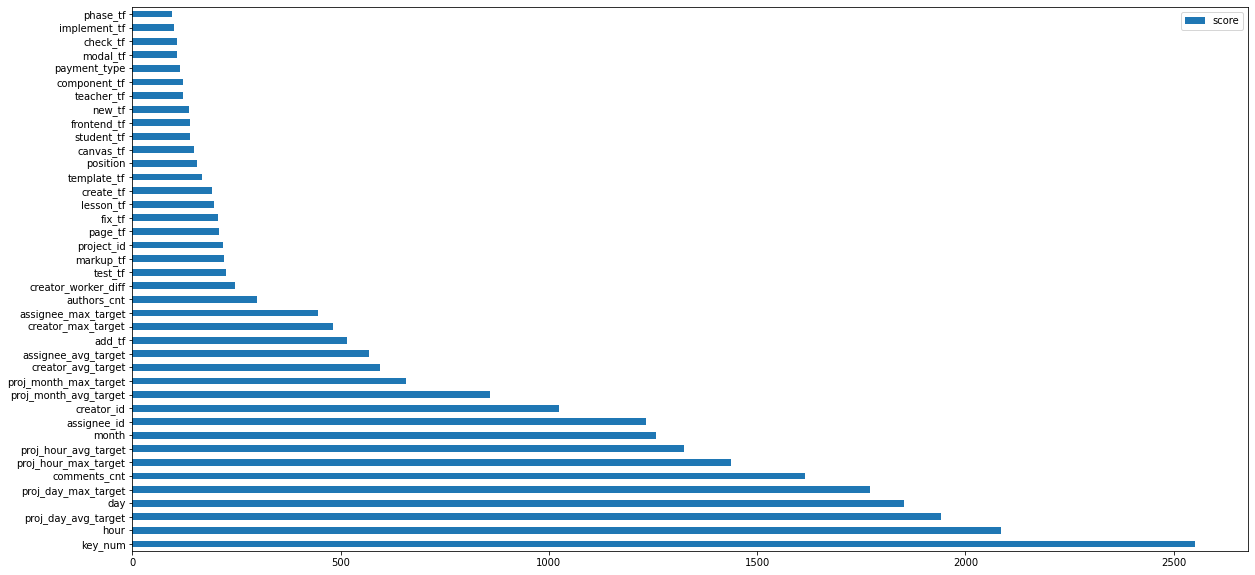

In [42]:
feature_importance = model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys,
                    columns=["score"]).sort_values(by="score", ascending=False)

data.nlargest(40, columns="score").plot(kind='barh', figsize=(20, 10)) ## plot top 40 features

# Сабмит на сайт

In [66]:
prediction_site = model.predict(df_test)
prediction_site = prediction_site + log_target_mean
prediction_site = np.exp(prediction_site)
prediction_site = np.rint(prediction_site).astype('int64')
prediction_site

array([12594,  8215,  9585, ...,  4599,  3274,  4176])

## Создаем таблицу с предсказаниями

In [67]:
df_solution = pd.read_csv('./data/sample_solution.csv')
df_solution.overall_worklogs = prediction_site
len(prediction_site), len(df_solution)

(1070, 1070)

In [68]:
df_solution.to_csv('./solutions/d19_new_params.csv', index=False)

## Проверяем предсказание

In [69]:
df_solution = pd.read_csv('./solutions/d19_new_params.csv')
df_solution.head()

,id,overall_worklogs
0,675975,12594
1,675972,8215
2,675965,9585
3,675961,9384
4,675955,9335


In [70]:
df_solution.describe()

,id,overall_worklogs
count,1.070000e+03,1070.000000
mean,7.970476e+05,8415.251402
std,2.869125e+05,6911.824739
min,6.709290e+05,782.000000
25%,7.208912e+05,4733.750000
50%,7.213915e+05,6708.000000
75%,7.217428e+05,9802.500000
max,2.183553e+06,107636.000000


In [71]:
df_solution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                1070 non-null   int64
 1   overall_worklogs  1070 non-null   int64
dtypes: int64(2)
memory usage: 16.8 KB
